In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import geopandas as gpd
import lxml
import missingno as msno
import numpy as np
import pandas as pd
from shapely.geometry import Point

from urbana.constants import DIR_REPO, DIR_DATA

In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2017
MONTH = 7

SAVE_INTERIM = True
OUTPUT_WARNINGS = False

In [5]:
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

# Open Data



## City maps

We will take a list of the neighbourhoods and districts with information to plot them from:

https://opendata-ajuntament.barcelona.cat/data/en/dataset/20170706-districtes-barris

In [6]:
geo_info = gpd.read_file(
    DIR_DATA / "raw/0301100100_UNITATS_ADM_POLIGONS.json"
)

sect = geo_info[geo_info["SCONJ_DESC"] == "Secció censal"]

sect = sect[["DISTRICTE", "BARRI", "SEC_CENS", "geometry"]]

# Change the coordinates to latitude and longitude
sect["geometry"] = sect["geometry"].to_crs("EPSG:4326")

sect.rename(
    {"DISTRICTE": "N_district", "BARRI": "N_neighbourhood", "SEC_CENS": "N_section"},
    axis=1,
    inplace=True,
)

sect["Tag"] = sect["N_district"] + "_" + sect["N_section"]
sect.sort_values(by=["Tag"], inplace=True)
sect.set_index("Tag", inplace=True)

We save the information required to plot the maps (`sect_geo`) in a JSON file. From now on, we will store the rest of the information in `sect` so it can be stores in a csv file that is easier to read for humans.

## Distance to city center

We assume the city center to be "Plaza Catalunya" (2.1700471, 41.3870154) and we will compute the distance of the centroid of each section to it.

To do so, we apply the *Haversine distance* between "Plaza Catalunya" and each centroid. Units chosen are km.

In [7]:
plaza_catalunya = Point(2.1700471, 41.3870154)
lon1 = np.radians(sect["geometry"].centroid.x)
lon2 = np.radians(plaza_catalunya.x)

lat2 = np.radians(plaza_catalunya.y)
lat1 = np.radians(sect["geometry"].centroid.y)
dlon = lon2 - lon1
dlat = lat2 - lat1
a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
c = 2 * np.arcsin(np.sqrt(a))
R_earth = 6371
d_haversine = c * R_earth
d_haversine = d_haversine.to_frame("Distance_Center")

sect = pd.merge(
    left=sect,
    right=d_haversine,
    how="left",
    left_index=True,
    right_index=True,
)

## POI

https://opendata-ajuntament.barcelona.cat/data/en/dataset/cens-activitats-comercials

In [8]:
econ = pd.read_csv(DIR_DATA / "raw/2019_censcomercialbcn_detall.csv")

econ = econ[
    [
        "Codi_Sector_Activitat",
        "Codi_Grup_Activitat",
        "Codi_Activitat_2019",
        "Nom_Grup_Activitat",
        "Codi_Districte",
        "Seccio_Censal",
    ]
]
econ.rename(
    {
        "Codi_Sector_Activitat": "Code_sector",
        "Codi_Grup_Activitat": "Code_group",
        "Nom_Grup_Activitat": "Name_Group",
        "Codi_Activitat_2019": "Code_activity",
        "Codi_Districte": "N_district",
        "Seccio_Censal": "N_section",
    },
    axis=1,
    inplace=True,
)

# Remove incorrect information
econ = econ[econ["Code_group"] != 0]
econ.dropna(subset=["N_section"], axis=0, inplace=True)
econ["N_section"] = econ["N_section"].astype("int")

econ["Tag"] = (
    econ["N_district"].map("{:02d}".format)
    + "_"
    + econ["N_section"].map("{:03d}".format)
)

econ.drop(["N_district", "N_section"], axis=1, inplace=True)

# Group by codes and count
econ = (
    econ.groupby(["Tag", "Code_sector", "Code_group", "Code_activity", "Name_Group"])
    .size()
    .to_frame("Count")
    .reset_index()
)

In [9]:
def sum_Points(acts):
    result = pd.DataFrame(index=sect.index)
    empty = pd.DataFrame(index=sect.index)
    for i in acts:
        empty[str(i)] = econ[econ["Code_activity"] == i].set_index("Tag")["Count"]
    empty.fillna(0, inplace=True)
    result["myResult"] = empty.sum(axis=1)
    return result["myResult"]

In [10]:
econ_list = pd.DataFrame(index=sect.index)
econ_group = (
    econ.groupby(["Tag", "Name_Group"])["Count"]
    .agg("sum")
    .to_frame("Count")
    .reset_index()
)

# LIST OF CATEGORIES DEFINED
econ_list["POI_Daily_Food"] = (
    econ_group[econ_group["Name_Group"] == "Quotidià alimentari"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Daily_Others"] = (
    econ_group[econ_group["Name_Group"] == "Quotidià no alimentari"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_House_Equipment"] = (
    econ_group[econ_group["Name_Group"] == "Parament de la llar"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Clothing"] = (
    econ_group[econ_group["Name_Group"] == "Equipament personal"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Culture"] = (
    econ_group[econ_group["Name_Group"] == "Oci i cultura"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Vehicles"] = (
    econ_group[econ_group["Name_Group"] == "Automoció"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_State_Agents"] = (
    econ_group[econ_group["Name_Group"] == "Activitats immobiliàries"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Education"] = (
    econ_group[econ_group["Name_Group"] == "Ensenyament"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Finances"] = (
    econ_group[econ_group["Name_Group"] == "Finances i assegurances"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Restaurants_Hotels"] = (
    econ_group[
        econ_group["Name_Group"]
        == "Restaurants, bars i hotels (Inclòs hostals, pensions i fondes)"
    ]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)
econ_list["POI_Health"] = (
    econ_group[econ_group["Name_Group"] == "Sanitat i assistència"]
    .drop("Name_Group", axis=1)
    .set_index("Tag")
)

econ_list["POI_Souvenirs_Thrift_Store"] = sum_Points([7004000, 7004010, 7004020])
econ_list["POI_Car_Parks"] = sum_Points([1600000])
econ_list["POI_Esthetics"] = sum_Points([1600600, 1600700, 1600800])
econ_list["POI_Sports"] = sum_Points([1700300, 1700310, 1700320])
econ_list["POI_Religion"] = sum_Points([1700400])
econ_list["POI_Administration"] = sum_Points([1700100])


econ_list.fillna(0, inplace=True)
econ_list = econ_list.astype("int")

# Merge the data
sect = pd.merge(
    left=sect,
    right=econ_list,
    how="left",
    left_index=True,
    right_index=True,
)

# Inside Airbnb

In [11]:
# Dates in which the files were uploaded (so far)
airbnb_dates = [
    "2015-04-30",
    "2015-07-17",
    "2015-09-04",
    "2015-10-02",
    "2016-01-03",
    "2016-11-07",
    "2016-12-08",
    "2017-01-04",
    "2017-02-09",
    "2017-03-06",
    "2017-04-08",
    "2017-05-07",
    "2017-06-05",
    "2017-07-06",
    "2017-08-06",
    "2017-09-12",
    "2017-10-07",
    "2017-11-13",
    "2017-12-09",
    "2018-01-17",
    "2018-02-07",
    "2018-04-12",
    "2018-05-14",
    "2018-06-09",
    "2018-07-10",
    "2018-08-14",
    "2018-09-11",
    "2018-10-10",
    "2018-11-07",
    "2018-12-10",
    "2019-01-14",
    "2019-02-06",
    "2019-03-08",
    "2019-04-10",
    "2019-05-14",
    "2019-06-07",
    "2019-07-10",
    "2019-08-12",
    "2019-09-17",
    "2019-10-16",
    "2019-11-09",
    "2019-12-10",
    "2020-01-10",
    "2020-02-16",
    "2020-03-16",
    "2020-04-16",
    "2020-05-11",
    "2020-06-13",
    "2020-07-17",
    "2020-08-24",
    "2020-09-12",
    "2020-10-12",
    "2020-11-06",
    "2020-12-16",
    "2021-01-12",
    "2021-02-09",
]

# Choose the data to download
airbnb_chosen = [
    i for i in airbnb_dates if i.startswith(str(YEAR) + "-" + "{:02d}".format(MONTH))
]
airbnb_chosen = pd.to_datetime(airbnb_chosen[0], format="%Y-%m-%d", errors="ignore")

In [12]:
airbnb_number_sect = sect[["N_district", "N_section"]]
airbnb_price_sect = sect[["N_district", "N_section"]]
airbnb_price_person_sect = sect[["N_district", "N_section"]]
airbnb_loc_review_sect = sect[["N_district", "N_section"]]

###########################################################
airbnb_url = (
    "http://data.insideairbnb.com/spain/catalonia/barcelona/"
    + airbnb_chosen.strftime("%Y-%m-%d")
    + "/data/listings.csv.gz"
)
df = pd.read_csv(airbnb_url)

print("File opened succesfully!")

date = airbnb_chosen.strftime("%Y_%m")

# Some rows are wrong
df = df[df["price"].str.contains("-") == False]

# Make the prices numbers and remove outliers (prices over 1000)
df["price"] = df["price"].str.replace("$", "").str.replace(",", "").astype("float")
df = df[df["price"] < 1000]
df["price_person"] = df["price"].div(df["accommodates"])
df["review_scores_location"] = df["review_scores_location"].astype("float")

df = df[["price", "price_person", "review_scores_location", "latitude", "longitude"]]

df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

df.drop(["longitude", "latitude"], axis=1, inplace=True)

# Set the column for the tags
df["Tag"] = -1

# Classify the Airbnbs based on their location
for i in range(len(sect.index)):
    selection = df["geometry"].within(sect["geometry"][i])
    selection_index = selection[selection].index
    df.loc[selection_index, "Tag"] = sect.index[i]

# Remove points that couldn't be classified
df = df[df["Tag"] != -1]

print("Positions processed succesfully!")


########################################################################################################################3
# # Extract the data from the file

temp_number_sect = (
    df["Tag"].value_counts().rename("Airbnb_Number").sort_index().to_frame()
)

temp_price_sect = (
    df.groupby(["Tag"])["price"].agg("mean").rename("Airbnb_Price").sort_index()
).to_frame()

temp_price_person_sect = (
    df.groupby(["Tag"])["price_person"]
    .agg("mean")
    .rename("Airbnb_Price_Person")
    .sort_index()
).to_frame()

temp_loc_review_sect = (
    df.groupby(["Tag"])["review_scores_location"]
    .agg("mean")
    .rename("Airbnb_Location_Score")
    .sort_index()
).to_frame()

sect = pd.merge(
    left=sect,
    right=temp_number_sect,
    how="left",
    left_index=True,
    right_index=True,
)

sect = pd.merge(
    left=sect,
    right=temp_price_sect,
    how="left",
    left_index=True,
    right_index=True,
)

sect = pd.merge(
    left=sect,
    right=temp_price_person_sect,
    how="left",
    left_index=True,
    right_index=True,
)


sect = pd.merge(
    left=sect,
    right=temp_loc_review_sect,
    how="left",
    left_index=True,
    right_index=True,
)

sect.fillna({"Airbnb_Number": 0}, inplace=True)
sect["Airbnb_Number"] = sect["Airbnb_Number"].astype("int")

File opened succesfully!
Positions processed succesfully!


# Barcelona City Council

## Gender

http://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a2017/sexe/sexe05.htm

In [13]:
table_gender = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/sexe/sexe05.htm",
    thousands=".",
)

gender = table_gender[0]
gender.columns = gender.loc[4]
gender.drop(
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 1077, 1078, 1079, 1080], axis=0, inplace=True
)
gender = gender.loc[:, ~gender.columns.duplicated()]
gender[["N_district", "N_section"]] = (
    gender["Dto. SC"].str.split(" ", 1, expand=True).astype("int")
)
gender["Tag"] = (
    gender["N_district"].map("{:02d}".format)
    + "_"
    + gender["N_section"].map("{:03d}".format)
)
gender.columns.name = None

gender.set_index("Tag", inplace=True)

gender["Mujeres"] = gender["Mujeres"].astype("int").div(gender["TOTAL"].astype("int"))

gender.drop(
    ["Dto. SC", "N_district", "N_section", "Hombres", "TOTAL"], axis=1, inplace=True
)

gender.rename({"Mujeres": "Percentage_Gender_Female"}, axis=1, inplace=True)

sect = pd.merge(
    left=sect,
    right=gender,
    how="left",
    left_index=True,
    right_index=True,
)

# Age

http://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a2017/edat/edatg11.htm

In [14]:
table_age = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/edat/edatg11.htm",
    thousands=".",
)

age = table_age[0]
age.columns = age.loc[4]
age.drop(
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 1077, 1078, 1079, 1080], axis=0, inplace=True
)
age = age.loc[:, ~age.columns.duplicated()]
age[["N_district", "N_section"]] = (
    age["Dto. SC"].str.split(" ", 1, expand=True).astype("int")
)
age["Tag"] = (
    age["N_district"].map("{:02d}".format) + "_" + age["N_section"].map("{:03d}".format)
)
age.columns.name = None

age.set_index("Tag", inplace=True)

age.rename(
    {
        "0-14 años": "Percentage_Age_0_14",
        "15-24 años": "Percentage_Age_15_24",
        "25-39 años": "Percentage_Age_25_39",
        "40-64 años": "Percentage_Age_40_64",
        "65 años y más": "Percentage_Age_65_Plus",
    },
    axis=1,
    inplace=True,
)

age.drop(["Dto. SC", "N_district", "N_section"], axis=1, inplace=True)

for col in reversed(age.columns):
    age[col] = age[col].astype("int").div(age["TOTAL"].astype("int"))

age.drop(["TOTAL"], axis=1, inplace=True)

sect = pd.merge(
    left=sect,
    right=age,
    how="left",
    left_index=True,
    right_index=True,
)

## Mean household

http://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a2017/llars/ocu04.htm

In [15]:
table_household = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/llars/ocu04.htm",
    thousands=".",
    decimal=",",
)

household = table_household[0]
household.columns = household.loc[4]
household.drop(
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 1077, 1078, 1079, 1080], axis=0, inplace=True
)
household = household.loc[:, ~household.columns.duplicated()]
household[["N_district", "N_section"]] = (
    household["Dto. SC"].str.split(" ", 1, expand=True).astype("int")
)
household["Tag"] = (
    household["N_district"].map("{:02d}".format)
    + "_"
    + household["N_section"].map("{:03d}".format)
)
household.columns.name = None

household.set_index("Tag", inplace=True)

household.drop(
    ["Dto. SC", "N_district", "N_section", "Población", "Domicilios"],
    axis=1,
    inplace=True,
)

household.rename(
    {"Ocupación media (personas por domicilio)": "Household"}, axis=1, inplace=True
)

household["Household"] = household["Household"].astype("float")

sect = pd.merge(
    left=sect,
    right=household,
    how="left",
    left_index=True,
    right_index=True,
)

## Education Level

Given the Spanish education system, the groups are defined as:


*   Elementary School = Primaria (6-12 years)
*   Middle School = Secundaria (13-16 years)
*   High School = Bachillerato (17-18 years)

The data is extracted from:


http://www.bcn.cat/estadistica/angles/dades/tpob/pad/padro/a2017/nivi/nivi05.htm

In [16]:
table_education = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/nivi/nivi11.htm",
    thousands=".",
)

education = table_education[0]
education.columns = education.loc[4]
education.drop(
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 1077, 1078, 1079, 1080, 1081, 1082],
    axis=0,
    inplace=True,
)
education = education.loc[:, ~education.columns.duplicated()]
education[["N_district", "N_section"]] = (
    education["Dto. SC"].str.split(" ", 1, expand=True).astype("int")
)
education["Tag"] = (
    education["N_district"].map("{:02d}".format)
    + "_"
    + education["N_section"].map("{:03d}".format)
)
education.columns.name = None

education.set_index("Tag", inplace=True)

education.rename(
    {
        "Sin estudios": "Education_None",
        "Estudios primarios / certificado de escolaridad / EGB": "Education_Primary_School",
        "Bachillerato elemental / graduado escolar / ESO / FPI": "Education_Middle_School",
        "Bachillerato superior / BUP / COU / FPII / CFGM grado medio": "Education_High_School",
        "Estudios universitarios / CFGS grado superior": "Education_University",
    },
    axis=1,
    inplace=True,
)


education.drop(
    ["Dto. SC", "N_district", "N_section", "No consta"],
    axis=1,
    inplace=True,
)

for col in reversed(education.columns):
    education[col] = education[col].astype("int").div(education["TOTAL"].astype("int"))

education.drop(
    ["TOTAL"],
    axis=1,
    inplace=True,
)

sect = pd.merge(
    left=sect,
    right=education,
    how="left",
    left_index=True,
    right_index=True,
)

## Country of Origin

http://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a2017/nacio/nacio11.htm

In [17]:
table_nationality = pd.read_html(
    "https://www.bcn.cat/estadistica/castella/dades/tpob/pad/padro/a"
    + str(YEAR)
    + "/nacio/nacio11.htm",
    thousands=".",
    decimal=",",
)

nationality = table_nationality[0]
nationality.columns = nationality.loc[5]
nationality.drop(
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1078, 1079, 1080, 1081],
    axis=0,
    inplace=True,
)
nationality = nationality.loc[:, ~nationality.columns.duplicated()]
nationality[["N_district", "N_section"]] = (
    nationality["Dto. SC"].str.split(" ", 1, expand=True).astype("int")
)
nationality["Tag"] = (
    nationality["N_district"].map("{:02d}".format)
    + "_"
    + nationality["N_section"].map("{:03d}".format)
)
nationality.columns.name = None

nationality.set_index("Tag", inplace=True)

nationality.drop(
    [
        "Dto. SC",
        "N_district",
        "N_section",
        "Total",
        "Resto países",
        "Apátridas / No consta",
    ],
    axis=1,
    inplace=True,
)

nationality.dropna(axis=1, inplace=True)
nationality = nationality.astype("int")
nationality.rename(
    {
        "España": "Nationality_Spain",
        "Italia": "Nationality_Italy",
        "Francia": "Nationality_France",
        "Reino Unido": "Nationality_UK",
        "Rumanía": "Nationality_Romania",
        "Alemania": "Nationality_Germany",
        "Rusia": "Nationality_Russia",
        "Ucrania": "Nationality_Ucrany",
        "Portugal": "Nationality_Portugal",
        "Países Bajos": "Nationality_Netherlands",
        "Polonia": "Nationality_Poland",
        "Bulgaria": "Nationality_Bulgaria",
        "Suecia": "Nationality_Sweden",
        "Bélgica": "Nationality_Belgium",
        "Irlanda": "Nationality_Ireland",
        "Grecia": "Nationality_Greece",
        "Marruecos": "Nationality_Morocco",
        "Argelia": "Nationality_Argelia",
        "Senegal": "Nationality_Senegal",
        "Bolivia": "Nationality_Bolivia",
        "Colombia": "Nationality_Colombia",
        "Perú": "Nationality_Peru",
        "Ecuador": "Nationality_Ecuador",
        "Honduras": "Nationality_Honduras",
        "Brasil": "Nationality_Brazil",
        "Venezuela": "Nationality_Venezuela",
        "Argentina": "Nationality_Argentina",
        "República Dominicana": "Nationality_Dominican_Republic",
        "Estados Unidos, los": "Nationality_USA",
        "México": "Nationality_Mexico",
        "Paraguay": "Nationality_Paraguay",
        "Chile": "Nationality_Chile",
        "Cuba": "Nationality_Cuba",
        "Uruguay": "Nationality_Uruguay",
        "el Salvador": "Nationality_Salvador",
        "China": "Nationality_China",
        "Pakistán": "Nationality_Pakistan",
        "Filipinas": "Nationality_Philippines",
        "India": "Nationality_India",
        "Bangladesh": "Nationality_Bangladesh",
        "Georgia": "Nationality_Georgia",
        "Armenia": "Nationality_Armenia",
        "Japón": "Nationality_Japan",
        "Nepal": "Nationality_Nepal",
        "Oceanía": "Nationality_Oceania",
    },
    axis=1,
    inplace=True,
)

for col in reversed(nationality.columns):
    nationality[col] = nationality[col].div(nationality["TOTAL"])

nationality.drop(["TOTAL"], axis=1, inplace=True)

sect = pd.merge(
    left=sect,
    right=nationality,
    how="left",
    left_index=True,
    right_index=True,
)

# Ministerio de Transportes, Movilidad y Agenda Urbana

https://www.mitma.gob.es/vivienda/alquiler/indice-alquiler

https://cdn.mitma.gob.es/portal-web-drupal/alquiler/Sistema_Indice_Alquiler_Vivienda.xlsx

In [18]:
rent = pd.read_excel(
    "https://cdn.mitma.gob.es/portal-web-drupal/alquiler/Sistema_Indice_Alquiler_Vivienda.xlsx",
    sheet_name="SeccionesCensales",
    converters={"CUDMUN": str, "CUSEC": str},
)
rent = rent[rent["CUDMUN"] == "08019"]
rent["Tag"] = rent["CUSEC"].str[5:7] + "_" + rent["CUSEC"].str[7:10]
rent.set_index("Tag", inplace=True)

rent = rent[
    [
        "BI_ALVHEPCO_TVC_" + str(YEAR)[2:4],
        "BI_ALVHEPCO_TVU_" + str(YEAR)[2:4],
        "ALQM2mes_LV_M_VC_" + str(YEAR)[2:4],
        "ALQM2mes_LV_M_VU_" + str(YEAR)[2:4],
        "ALQTBID12_M_VC_" + str(YEAR)[2:4],
        "ALQTBID12_M_VU_" + str(YEAR)[2:4],
        "SLVM2_M_VC_" + str(YEAR)[2:4],
        "SLVM2_M_VU_" + str(YEAR)[2:4],
    ]
]

rent.rename(
    {
        "BI_ALVHEPCO_TVC_" + str(YEAR)[2:4]: "Rent_Number_Flats",
        "BI_ALVHEPCO_TVU_" + str(YEAR)[2:4]: "Rent_Number_Detached",
        "ALQM2mes_LV_M_VC_" + str(YEAR)[2:4]: "Rent_Price_Meter_Flats",
        "ALQM2mes_LV_M_VU_" + str(YEAR)[2:4]: "Rent_Price_Meter_Detached",
        "ALQTBID12_M_VC_" + str(YEAR)[2:4]: "Rent_Price_Total_Flats",
        "ALQTBID12_M_VU_" + str(YEAR)[2:4]: "Rent_Price_Total_Detached",
        "SLVM2_M_VC_" + str(YEAR)[2:4]: "Rent_Area_Flats",
        "SLVM2_M_VU_" + str(YEAR)[2:4]: "Rent_Area_Detached",
    },
    axis=1,
    inplace=True,
)

rent.fillna({"Rent_Number_Flats": 0, "Rent_Number_Detached": 0}, inplace=True)
rent["Rent_Number_Flats"] = rent["Rent_Number_Flats"].astype("int")
rent["Rent_Number_Detached"] = rent["Rent_Number_Detached"].astype("int")

sect = pd.merge(
    left=sect,
    right=rent,
    how="left",
    left_index=True,
    right_index=True,
)

# Check missing values

<AxesSubplot:>

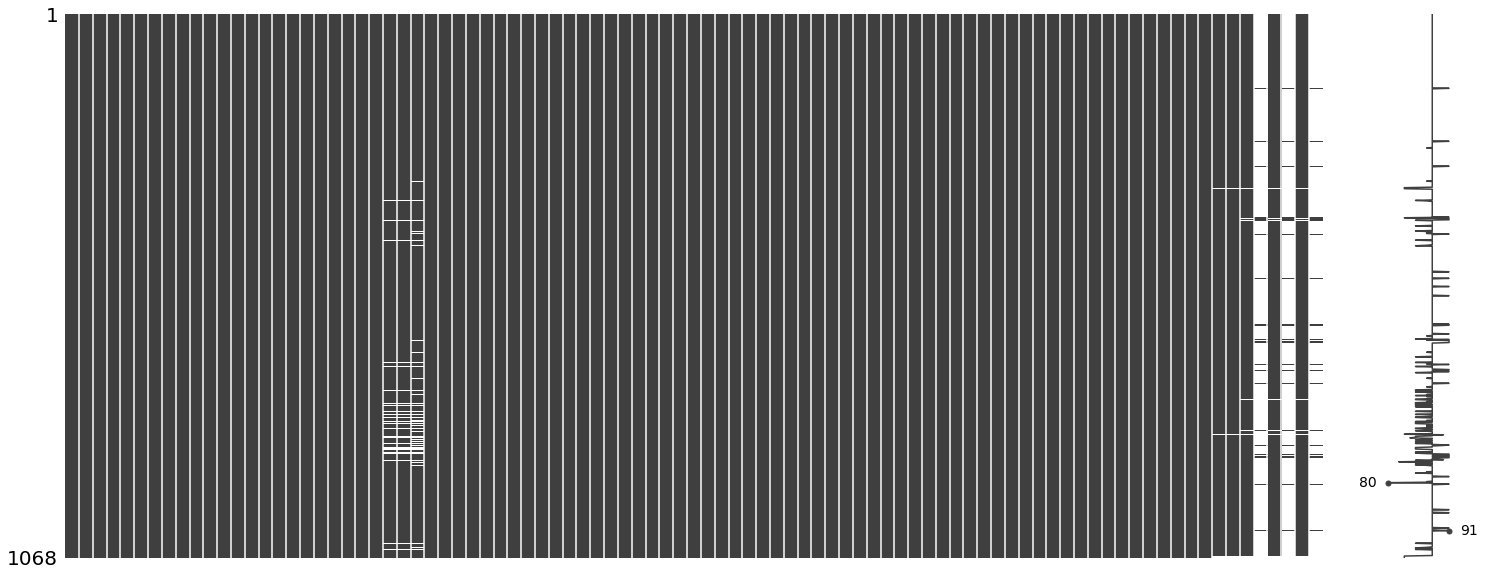

In [19]:
msno.matrix(sect)

The features related to detached houses have around 90% of missing values. Therefore, we will drop the following features:
* *Rent_Number_Detached*
* *Rent_Price_Meter_Detached*
* *Rent_Price_Total_Detached*
* *Rent_Area_Detached*

For ther rest, the number of missing values is not significant. We will use an imputer in later stages to fill those values.

In [20]:
sect.drop(
    [
        "Rent_Number_Detached",
        "Rent_Price_Meter_Detached",
        "Rent_Price_Total_Detached",
        "Rent_Area_Detached",
    ],
    axis=1,
    inplace=True,
)

# Save Data

In [21]:
if SAVE_INTERIM:
    sect.to_file(DIR_DATA / "interim/sections_geo.json", driver="GeoJSON")
    sect.drop(["geometry"], axis=1, inplace=True)
    sect.to_csv(DIR_DATA / "interim/sections.csv")

In [22]:
sect

,N_district,N_neighbourhood,N_section,Distance_Center,POI_Daily_Food,POI_Daily_Others,POI_House_Equipment,POI_Clothing,POI_Culture,POI_Vehicles,...,Nationality_Bangladesh,Nationality_Georgia,Nationality_Armenia,Nationality_Japan,Nationality_Nepal,Nationality_Oceania,Rent_Number_Flats,Rent_Price_Meter_Flats,Rent_Price_Total_Flats,Rent_Area_Flats
Tag,,,,,,,,,,,,,,,,,,,,,
01_001,01,01,001,1.532922,6,1,0,0,2,0,...,0.073318,0.000000,0.000000,0.004535,0.000756,0.000756,103.0,12.339529,702.0,56.0
01_002,01,01,002,1.060772,3,2,1,2,1,0,...,0.097411,0.000617,0.006782,0.000000,0.000617,0.000617,64.0,12.941176,899.0,64.0
01_003,01,01,003,1.262231,9,3,1,2,3,0,...,0.036190,0.000290,0.000869,0.000869,0.006369,0.000000,160.0,13.018108,606.0,50.0
01_004,01,01,004,1.180517,13,4,8,2,5,0,...,0.051961,0.001032,0.000344,0.001721,0.002409,0.000688,157.0,12.517755,688.0,55.0
01_005,01,01,005,0.937494,20,4,2,2,38,0,...,0.038308,0.003990,0.000798,0.000000,0.000399,0.000399,113.0,11.503987,696.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10_143,10,73,143,5.233053,2,1,0,0,0,0,...,0.000573,0.003436,0.008018,0.000000,0.000000,0.000000,52.0,7.812500,700.0,84.0
10_234,10,65,234,2.715310,4,2,2,1,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
10_235,10,69,235,4.287328,3,2,0,1,0,0,...,0.000000,0.000745,0.002234,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN


# Watermark

In [23]:
%load_ext watermark

In [24]:
# NBVAL_IGNORE_OUTPUT
%watermark -a "Ernesto Gregori" -u -d -t -v -m -g -wb

Author: Ernesto Gregori

Last updated: 2021-04-14 16:22:53

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.8.0-48-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 0d4a5de134073a6916c8b74a514d792c1ff3474c

Git branch: master

Watermark: 2.2.0



In [25]:
# NBVAL_IGNORE_OUTPUT
%watermark -iv

pandas   : 1.2.3
missingno: 0.4.2
lxml     : 4.6.3
numpy    : 1.20.2
geopandas: 0.9.0

